## Подключаем необходимые модули

In [1]:
!git clone https://github.com/yegrDx/object_classification

Cloning into 'object_classification'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 135 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (135/135), 8.31 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.15.0
GPU is OFF


## Подготовим набор данных для обучения

In [5]:
CLASSES = 5

COLORS = ['black', 'red', 'lime',
          'blue', 'orange']

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (1920, 1280)

In [6]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    # Ensure mask has three channels
    if mask.shape[-1] != 3:
        mask = tf.image.grayscale_to_rgb(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    masks = []

    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)

    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)

    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [7]:
images = sorted(glob.glob('object_classification/images/*.jpg'))
masks = sorted(glob.glob('object_classification/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(40)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

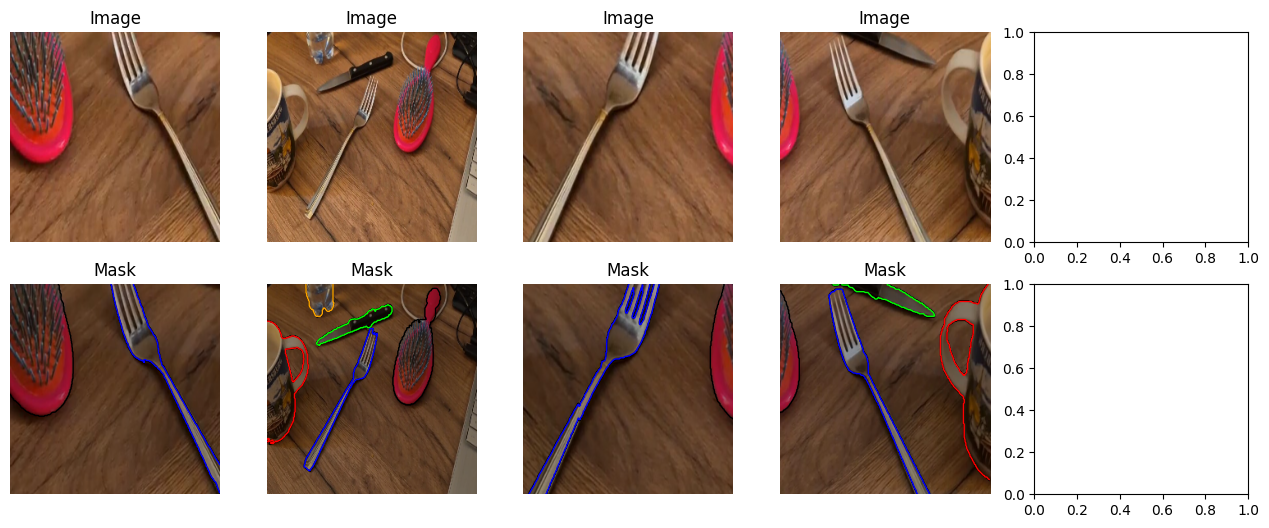

In [8]:
images_and_masks = list(dataset.take(4))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)

    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()
    ax[1, i].imshow(image/1.5)

    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()


## Посмотрим на содержимое набора данных

## Разделим набор данных на обучающий и проверочный

In [9]:
train_dataset = dataset.take(2400).cache()
test_dataset = dataset.skip(2400).take(200).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

## Обозначим основные блоки модели

In [10]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))

    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

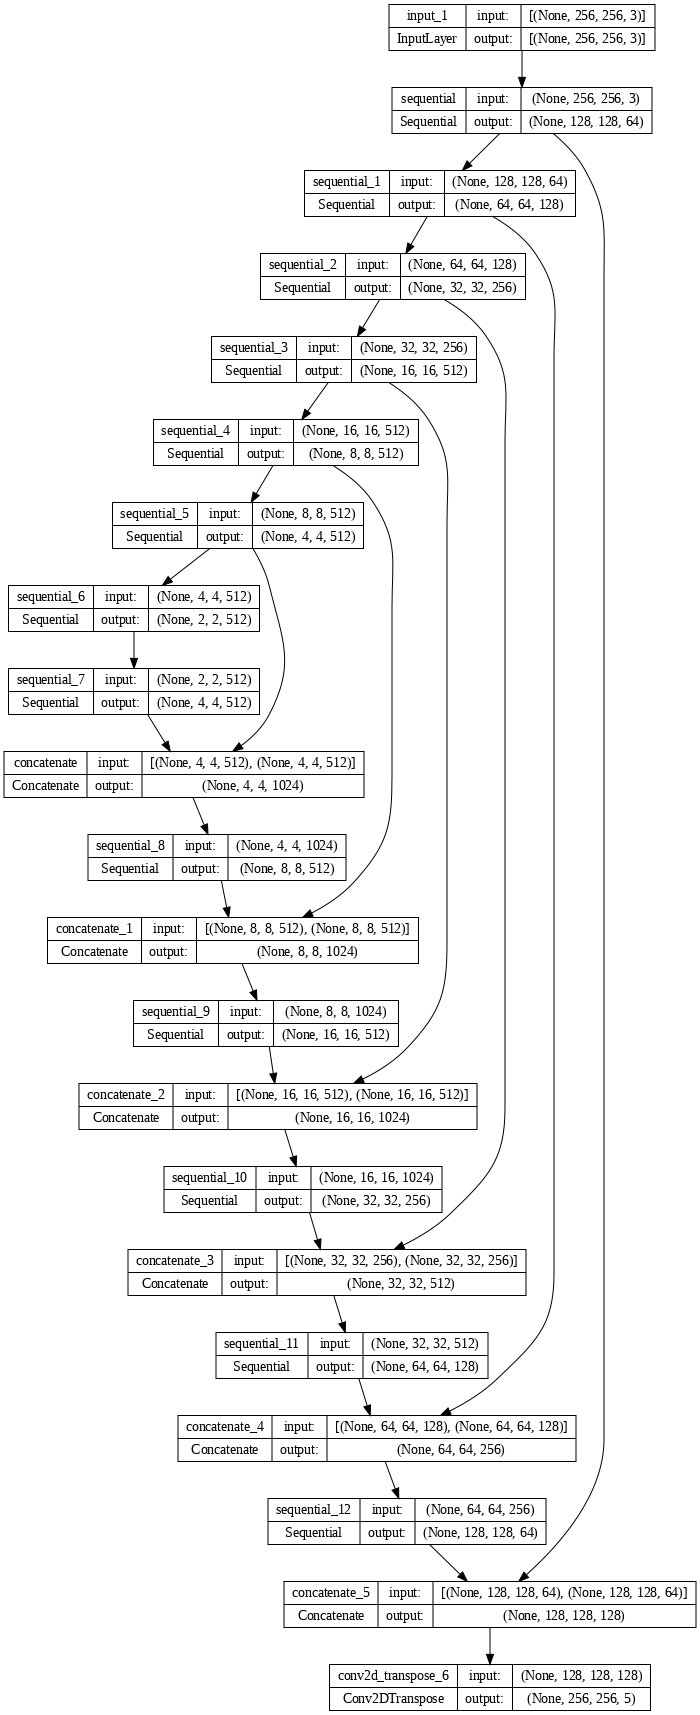

In [11]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

## Определим метрики и функции потерь

In [12]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)

    dice_summ = 0

    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator

    avg_dice = dice_summ / CLASSES

    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

## Компилируем модель

In [13]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [ ]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=20, initial_epoch=0)

unet_like.save_weights('object_classification/networks/unet_like')
#unet_like.save_weights('drive/MyDrive/od1.4/neural_network/unet_like')

Epoch 1/20
  3/300 [..............................] - ETA: 1:13:22 - loss: 0.7477 - dice_mc_metric: 0.2047

In [15]:
unet_like.save_weights('object_classification/networks/unet_like')

## Загружаем обученную модель

In [ ]:
unet_like.load_weights('object_classification/networks/unet_like')

:## Проверим работу сети на всех кадрах из тестового видео

In [ ]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('drive/MyDrive/od1.4/videos/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'drive/MyDrive/od1.4/proc_video/{os.path.basename(filename)}', frame)

1/1 [==============================] - 0s 19ms/step
